# Steepest descent

Consider $f \in C^1$. The steepest descent consists to iteratively compute
$$
x_{k+1} = x_k - \alpha^* \nabla f(x^k)
$$
where $\alpha^* \in \arg\min_{\alpha \geq 0} f(x_k - \alpha \nabla f(x_k))$.

In [20]:
using Optim
using Plots
plotly()
#pyplot()

Plots.PlotlyBackend()

We need the LinearAlgebra library to access some methods as det, that computes a matrix determinant.

In [21]:
using LinearAlgebra

## Example 1

Consider the bivariate function
$$
f(x, y) = 4x^2 - 4xy + 2y^2
$$

In [22]:
f1(x) = 4x[1]*(x[1]-x[2])+2*x[2]*x[2]

default(size=(600,600), fc=:heat)
x, y = -2.5:0.1:2.5, 0.5:0.1:2.5
z = Surface((x,y)->f1([x,y]), x, y)
surface(x,y,z)

<!DOCTYPE html>
 
 
 Plots.jl

Its gradient is
$$
\nabla f(x, y) = \begin{pmatrix} 8x - 4y \\ 4y - 4x \end{pmatrix}
$$
The Hessian is
$$
\nabla f^2(x,y) =
\begin{pmatrix}
8 & -4 \\ -4 & 4
\end{pmatrix}
$$

In [8]:
A = [8 -4; -4 4 ]

2×2 Array{Int64,2}:
  8  -4
 -4   4

The principal minors determinants are

In [9]:
8
det( A )

16.0

Therefore, the matrix is positive definite. We can confirm this by computing the eigenvalues:

In [10]:
eigvals(A)

2-element Array{Float64,1}:
  1.5278640450004206
 10.47213595499958  

We compute the gradient as

In [11]:
function f1grad(x)
    return [8*x[1]-4*x[2], 4*x[2]-4*x[1]]
end

f1grad (generic function with 1 method)

Consider $x_0 = (2, 3)$. Therefore $\nabla f(x_0) = (4, 4)$.

We have to minimize the univariate function
$$
m(\alpha) = f((2, 3) - \alpha(4, 4)) = f(2 - 4\alpha, 3 - 4\alpha)
$$
The derivative of $m(\alpha)$ is
\begin{align*}
m'(\alpha) &= \nabla_{(x,y)} f(2 - 4\alpha, 3 - 4\alpha)^T \nabla_{\alpha} \begin{pmatrix} 2 - 4\alpha \\ 3 - 4\alpha \end{pmatrix} \\
&= \begin{pmatrix} 8(2-4\alpha) - 4(3-4\alpha) & 4(3-4\alpha) - 4(2-4\alpha)\end{pmatrix}\begin{pmatrix} -4 \\ -4 \end{pmatrix} \\
&= -\begin{pmatrix} 4 - 16\alpha & 4\end{pmatrix}\begin{pmatrix} 4 \\ 4 \end{pmatrix} \\
&= -16+64\alpha-16\\
&= 64\alpha-32
\end{align*}

The second derivate of $m(\alpha)$ is
$$
m''(\alpha) = 64
$$
Therefore the unidimensionel model is strictly convex. The minimizer can be found by setting $m'(\alpha^*) = 0$, leading to $\alpha^* = \frac{1}{2}$. Therefore
$$
x_1 = x_0 - \frac{1}{2}\nabla f(x_0) = (2, 3) - \frac{1}{2}(4, 4) = (0, 1),
$$
and
$$
\nabla f(x_1) = \begin{pmatrix} -4 \\ 4 \end{pmatrix}
$$
The univariate function to minimize is now
$$
m(\alpha) = f((0, 1) - \alpha(-4, 4)) = f(4\alpha, 1 - 4\alpha)
$$
and its derivative is
\begin{align*}
m'(\alpha) &= \nabla_{(x,y)} f(4\alpha, 1 - 4\alpha)^T \nabla_{\alpha} \begin{pmatrix} 4\alpha \\ 1 - 4\alpha \end{pmatrix} \\
&= ( 8 \times 4\alpha - 4(1-4\alpha), 4(1-4\alpha) - 4\times(4\alpha))\begin{pmatrix} 4 \\ -4 \end{pmatrix} \\
&= ( -4 + 48\alpha, 4 - 32 \alpha)\begin{pmatrix} 4 \\ -4 \end{pmatrix} \\
&= -32+320\alpha
\end{align*}
The root of $m'(\alpha)$ is $\alpha^* = \frac{1}{10}$, and $m''(\alpha) = 320$, thus $\alpha^*$ is a global minimizer.
We obtain
$$
x_2 = \begin{pmatrix} 0 \\ 1 \end{pmatrix} - \frac{1}{10}\begin{pmatrix} -4 \\ 4 \end{pmatrix}
= \begin{pmatrix} \frac{4}{10} \\ \frac{6}{10} \end{pmatrix}
= \begin{pmatrix} \frac{2}{5} \\ \frac{3}{5} \end{pmatrix}
$$
We could continue, but such a hand computation is tedious. We will automatize the procedure by constructing a Julia function.

In [12]:
function steepestdescent(f::Function, fprime::Function, x0, h::Float64, verbose::Bool = true,
                         record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end
    
    while ((k < maxiter) && (norm(grad) > tol))
        α = Optim.minimizer(optimize(fsearch, 0, h, GoldenSection()))
        x = x-α*grad
        k += 1
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx")
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

steepestdescent (generic function with 5 methods)

The following variant proposes to enlarge the interval where the unidimensional search is done when the upper bound is reached.

This is only valid for convex functions!

But the idea will be adapted and generalized when discussing about trust regions.

In [13]:
function steepestdescent_convex(f::Function, fprime::Function, x0, h::Float64, verbose::Bool = true,
        record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end

    Δ = 1e-6
    
    while ((k < maxiter) && (norm(grad) > tol))
        α = Optim.minimizer(optimize(fsearch, 0, h, GoldenSection()))
        while ((h-α) <= Δ)
            h *= 2
            α = Optim.minimizer(optimize(fsearch, α, h, GoldenSection()))
        end
        h = α
        x = x-α*grad
        k += 1
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx")
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

steepestdescent_convex (generic function with 5 methods)

Executing this function on the problem, we obtain

In [14]:
sol, iter = steepestdescent(f1, f1grad, [2.0,3.0], 2.0, true, true)

0. x = [2.0, 3.0], f([2.0, 3.0]) = 10.0
1. x = [3.3384826014781765e-9, 1.0000000033384826], f([3.3384826014781765e-9, 1.0000000033384826]) = 2.0
2. x = [0.4000000056568157, 0.5999999996847565], f([0.4000000056568157, 0.5999999996847565]) = 0.4000000042732578
3. x = [1.2686234840408872e-8, 0.20000004191604126], f([1.2686234840408872e-8, 0.20000004191604126]) = 0.08000002338384717
4. x = [0.08000002003440877, 0.12000002949337335], f([0.08000002003440877, 0.12000002949337335]) = 0.01600000792444612
5. x = [1.2797865406311004e-9, 0.04000001297171028], f([1.2797865406311004e-9, 0.04000001297171028]) = 0.003200001870708075
6. x = [0.016000005590790508, 0.024000008148791697], f([0.016000005590790508, 0.024000008148791697]) = 0.0006400004396667061
7. x = [4.5701057174718507e-10, 0.008000003964587964], f([4.5701057174718507e-10, 0.008000003964587964]) = 0.00012800011224250156
8. x = [0.0032000017064671205, 0.004800002532327185], f([0.0032000017064671205, 0.004800002532327185]) = 2.5600027128290

([8.192019638207948e-9, 1.2288029327965716e-8], [10.0 2.0 3.0; 2.0 3.3384826014781765e-9 1.0000000033384826; … ; 8.388647356522391e-16 5.772500948176087e-16 2.048004861982361e-8; 1.677729622627484e-16 8.192019638207948e-9 1.2288029327965716e-8])

In [15]:
sol, iter = steepestdescent(f1, f1grad, [10.0,10.0], 2.0, true, true)

0. x = [10.0, 10.0], f([10.0, 10.0]) = 200.0
1. x = [5.000000000465118, 10.0], f([5.000000000465118, 10.0]) = 100.0
2. x = [4.999999999534882, 4.9999999754264985], f([4.999999999534882, 4.9999999754264985]) = 49.999999990697646
3. x = [2.499999987945808, 4.99999998748069], f([2.499999987945808, 4.99999998748069]) = 24.9999998748069
4. x = [2.499999999534882, 2.4999999754264985], f([2.499999999534882, 2.4999999754264985]) = 12.49999999534882
5. x = [1.2499999878295287, 2.49999998748069], f([1.2499999878295287, 2.49999998748069]) = 6.24999993740345
6. x = [1.2499999996511608, 1.2500000252711772], f([1.2499999996511608, 1.2500000252711772]) = 3.1249999982558054
7. x = [0.6249999960013161, 1.2500000124611685], f([0.6249999960013161, 1.2500000124611685]) = 1.562500031152922
8. x = [0.6250000164598511, 0.6250000365727931], f([0.6250000164598511, 0.6250000365727931]) = 0.7812500411496293
9. x = [0.3125000099692602, 0.6250000265163219], f([0.3125000099692602, 0.6250000265163219]) = 0.390625033

([1.862646628163515e-8, 3.725293376026287e-8], [200.0 10.0 10.0; 100.0 5.000000000465118 10.0; … ; 2.7755619382292965e-15 3.7252932355918514e-8 3.7252935164607425e-8; 1.3877810737465348e-15 1.862646628163515e-8 3.725293376026287e-8])

In [16]:
sol, iter = steepestdescent(f1, f1grad, [100.0,100.0], 2.0, true, true)

0. x = [100.0, 100.0], f([100.0, 100.0]) = 20000.0
1. x = [50.00000000465118, 100.0], f([50.00000000465118, 100.0]) = 10000.0
2. x = [49.99999999534882, 49.99999975426499], f([49.99999999534882, 49.99999975426499]) = 4999.999999069764
3. x = [24.999999879458084, 49.9999998748069], f([24.999999879458084, 49.9999998748069]) = 2499.9999874806904
4. x = [24.99999999534882, 24.99999975426499], f([24.99999999534882, 24.99999975426499]) = 1249.9999995348821
5. x = [12.49999987829529, 24.999999874806903], f([12.49999987829529, 24.999999874806903]) = 624.9999937403452
6. x = [12.49999999651161, 12.500000252711775], f([12.49999999651161, 12.500000252711775]) = 312.49999982558063
7. x = [6.249999960013162, 12.50000012461169], f([6.249999960013162, 12.50000012461169]) = 156.2500031152923
8. x = [6.250000164598514, 6.250000365727932], f([6.250000164598514, 6.250000365727932]) = 78.125004114963
9. x = [3.1250000996926026, 6.25000026516322], f([3.1250000996926026, 6.25000026516322]) = 39.062503314540

([2.3283061655662933e-8, 4.656612314936741e-8], [20000.0 100.0 100.0; 10000.0 50.00000000465118 100.0; … ; 4.3368077641337195e-15 4.656612376037819e-8 4.656612253835665e-8; 2.1684038251620514e-15 2.3283061655662933e-8 4.656612314936741e-8])

We converge to the solution $(0,0)$, but the method was quite slow close to the solution.

In [17]:
sol, iter = steepestdescent(f1, f1grad, [2.0,3.0], 0.1, true, true)

0. x = [2.0, 3.0], f([2.0, 3.0]) = 10.0
1. x = [1.6000000074048677, 2.6000000074048675], f([1.6000000074048677, 2.6000000074048675]) = 7.120000047391152
2. x = [1.3600000088858413, 2.2000000148097354], f([1.3600000088858413, 2.2000000148097354]) = 5.110400068243261
3. x = [1.1520000115515936, 1.8640000186602665], f([1.1520000115515936, 1.8640000186602665]) = 3.6680960734752444
4. x = [0.9760000130325671, 1.579200021089063], f([0.9760000130325671, 1.579200021089063]) = 2.632852550317856
5. x = [0.8268800138026734, 1.337920022333081], f([0.8268800138026734, 1.337920022333081]) = 1.8897848950901366
6. x = [0.7005440140325205, 1.1335040227051016], f([0.7005440140325205, 1.1335040227051016]) = 1.3564325694131156
7. x = [0.593510413869969, 0.9603200224420807], f([0.593510413869969, 0.9603200224420807]) = 0.9736078006258554
8. x = [0.5028300934295156, 0.8135961817294126], f([0.5028300934295156, 0.8135961817294126]) = 0.6988273289911094
9. x = [0.4260044927998767, 0.6892897487106355], f([0.426

83. x = [1.9993558662914607e-6, 3.2350257472660737e-6], f([1.9993558662914607e-6, 3.2350257472660737e-6]) = 1.1048607869643784e-11
84. x = [1.6938814778197153e-6, 2.7407578040262003e-6], f([1.6938814778197153e-6, 2.7407578040262003e-6]) = 7.930369006544579e-12
85. x = [1.4350794219654107e-6, 2.322007281295587e-6], f([1.4350794219654107e-6, 2.322007281295587e-6]) = 5.692187950009173e-12
86. x = [1.2158188009703066e-6, 1.9672361441310998e-6], f([1.2158188009703066e-6, 1.9672361441310998e-6]) = 4.0856867607913985e-12
87. x = [1.0300582212853326e-6, 1.6666692124309284e-6], f([1.0300582212853326e-6, 1.6666692124309284e-6]) = 2.932586986569762e-12
88. x = [8.726793321428626e-7, 1.4120248206867102e-6], f([8.726793321428626e-7, 1.4120248206867102e-6]) = 2.104925545523829e-12
89. x = [7.393457971715496e-7, 1.196286629262953e-6], f([7.393457971715496e-7, 1.196286629262953e-6]) = 1.5108542636552369e-12
90. x = [6.263838132306625e-7, 1.0135102998099781e-6], f([6.263838132306625e-7, 1.0135102998099

([3.1674739210844834e-8, 5.125080462793596e-8], [10.0 2.0 3.0; 7.120000047391152 1.6000000074048677 2.6000000074048675; … ; 3.86338169357254e-15 3.738695799187142e-8 6.049336876681246e-8; 2.773022882578525e-15 3.1674739210844834e-8 5.125080462793596e-8])

In [18]:
sol, iter = steepestdescent_convex(f1, f1grad, [2.0,3.0], 0.1, true, true)

0. x = [2.0, 3.0], f([2.0, 3.0]) = 10.0
1. x = [-6.864689705565752e-9, 0.9999999931353103], f([-6.864689705565752e-9, 0.9999999931353103]) = 2.0
2. x = [0.39999999550607185, 0.5999999935104245], f([0.39999999550607185, 0.5999999935104245]) = 0.3999999912131972
3. x = [-4.951900556271482e-10, 0.19999999650389555], f([-4.951900556271482e-10, 0.19999999650389555]) = 0.0799999975992685
4. x = [0.07999999835247451, 0.11999999785430701], f([0.07999999835247451, 0.11999999785430701]) = 0.015999999393085048
5. x = [-6.581302169905712e-10, 0.03999999754132129], f([-6.581302169905712e-10, 0.03999999754132129]) = 0.0031999997119122486
6. x = [0.015999998860773402, 0.023999998285669757], f([0.015999998860773402, 0.023999998285669757]) = 0.0006399999086861844
7. x = [-4.1769140229908075e-11, 0.007999999405088599], f([-4.1769140229908075e-11, 0.007999999405088599]) = 0.00012799998229944828
8. x = [0.0031999997458548846, 0.00479999963417223], f([0.0031999997458548846, 0.00479999963417223]) = 2.559999

([8.192001380727594e-9, 1.228800200709067e-8], [10.0 2.0 3.0; 2.0 -6.864689705565752e-9 0.9999999931353103; … ; 8.388607278346872e-16 2.667964187437204e-15 2.0480001787039767e-8; 1.6777221550601903e-16 8.192001380727594e-9 1.228800200709067e-8])

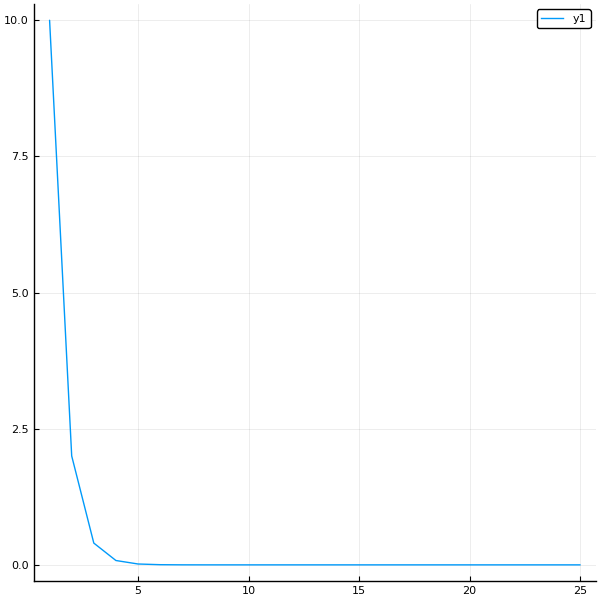

In [19]:
k = [x = i for i=1:length(iter[:,1])]
Plots.plot(k,iter[:,1])

In [ ]:
k

In [ ]:
k = [x = i for i=10:length(iter[:,1])]
Plots.plot(k,iter[10:length(iter[:,1]),1])

## Coordinate descent

In [ ]:
function Jacobi(f::Function, x0, h::Float64, verbose::Bool = true, δ::Float64 = 1e-6, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x0-α*d))
    end

    x = copy(x0)
    n = length(x)
    k = 0
    d = zeros(n)
    
    while true
        x0[:] = x[:]
        k += 1
        
        for i = 1:n
            d[i] = 1.0  # d is now the i^th vector of the canonical basis
            α = Optim.minimizer(optimize(fsearch, 0, h, GoldenSection()))
            x[i] -= α
            d[i] = 0.0
        end
        
        if verbose
            println(k, ". ", f(x), " ", x, " ", x0)
        end
        
        if norm(x-x0) < δ
            break
        end
    end
    
    return x
end

In [ ]:
sol = Jacobi(f1, [2.0,3.0], 1.0)

## Exemple 2

Consider the bivariate function
$$
f(x,y) = \frac{(2-x)^2}{2y^2}+\frac{(3-x)^2}{2y^2} + \ln y
$$
that is computed in Julia as

In [ ]:
f(x) = (2-x[1])*(2-x[1])/(2*x[2]*x[2])+(3-x[1])*(3-x[1])/(2*x[2]*x[2])+log(x[2])

Its derivative is
$$
\nabla f(x) =
\begin{pmatrix}
\frac{-2(2-x)}{2y^2}+\frac{-2(3-x)}{2y^2} \\
-\frac{(2-x)^2}{y^3}-\frac{(3-x)^2}{y^3} + \frac{1}{y}
\end{pmatrix} =
\begin{pmatrix}
\frac{x-2}{y^2}+\frac{x-3}{y^2} \\
-\frac{(2-x)^2}{y^3}-\frac{(3-x)^2}{y^3} + \frac{1}{y}
\end{pmatrix}
$$

In [ ]:
function fprime(x)
    return [(x[1]-2)/(x[2]*x[2])+(x[1]-3)/(x[2]*x[2]),
            -(2-x[1])*(2-x[1])/(x[2]*x[2]*x[2])-(3-x[1])*(3-x[1])/(x[2]*x[2]*x[2])+1/x[2]]
end

In [ ]:
default(size=(600,600), fc=:heat)
x, y = -2.5:0.1:2.5, 0.5:0.1:2.5
z = Surface((x,y)->f([x,y]), x, y)
surface(x,y,z, linealpha = 0.3)

In [ ]:
sol = steepestdescent(f, fprime, [1.0,1.0], 2.0)

The choice of $h$ is important. Consider for instance a too small value: $h = 0.1$.

In [ ]:
sol = steepestdescent(f, fprime, [1.0,1.0], 0.1)

But a too big $h$ can lead to some issues too. Consider for instance $h = 10$.

In [ ]:
sol = steepestdescent(f, fprime, [1.0,1.0], 10.0)

We will have to ensure that the iterates are such that $y > 0$ due to the logarithmic operator.

The choice of the starting point is also important to ensure that the algorithm converges fast enough. Consider for instance $x_0 = (0.1, 0.1)$.

In [ ]:
sol = steepestdescent(f, fprime, [0.1,0.1], 2.0)

Now, take $x_0 = (100, 100)$.

In [ ]:
sol = steepestdescent(f, fprime, [100.0,100.0], 5.0)

In practice, we often need some insight on the function to optimize in order to be efficient.

## Rosenbrock function

$$
f(x,y) = (1-x)^2 + 100(y-x^2)^2
$$

$$
\nabla f(x,y) =
\begin{pmatrix}
-2(1-x)-400x(y-x^2) \\
200(y-x^2)
\end{pmatrix}
$$

$$
\nabla^2 f(x,y) =
\begin{pmatrix}
2 - 400(y-x^2) + 800x^2 & -400x \\
-400x & 200
\end{pmatrix}
=
\begin{pmatrix}
2 - 400y + 1200x^2 & -400x \\
-400x & 200
\end{pmatrix}
$$

In [23]:
function rosenbrock(x::Vector)
  return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end
 
function rosenbrock_gradient(x::Vector)
  return [-2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1],
          200.0 * (x[2] - x[1]^2)]
end
 
function rosenbrock_hessian(x::Vector)
  h = zeros(2, 2)
  h[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
  h[1, 2] = -400.0 * x[1]
  h[2, 1] = -400.0 * x[1]
  h[2, 2] = 200.0
  return h
end

rosenbrock_hessian (generic function with 1 method)

In [24]:
default(size=(600,600))
x, y = 0:0.01:1.0, 0:0.01:1.0
z = Surface((x,y)->rosenbrock([x,y]), x, y)
surface(x,y,z, linealpha = 0.3)

<!DOCTYPE html>
 
 
 Plots.jl

In [25]:
Plots.contour(x,y,z, linealpha = 0.1, levels=2500)

<!DOCTYPE html>
 
 
 Plots.jl

In [26]:
sol, iter = steepestdescent(rosenbrock, rosenbrock_gradient, [0.0,0.0], 10.0, true, true)

0. x = [0.0, 0.0], f([0.0, 0.0]) = 1.0
1. x = [0.1612620227407261, 0.0], f([0.1612620227407261, 0.0]) = 0.7711096853441531
2. x = [0.16126202280695034, 0.02600544024872085], f([0.16126202280695034, 0.02600544024872085]) = 0.7034813943858886
3. x = [0.21133888041724883, 0.02600543876247529], f([0.21133888041724883, 0.02600543876247529]) = 0.6568010089605405
4. x = [0.21133888100318554, 0.04466412256994727], f([0.21133888100318554, 0.04466412256994727]) = 0.6219863606173075
5. x = [0.24508247498253186, 0.04466412279984179], f([0.24508247498253186, 0.04466412279984179]) = 0.5936204637173165
6. x = [0.2450824743849232, 0.06006541860916487], f([0.2450824743849232, 0.06006541860916487]) = 0.5699004704807902
7. x = [0.2711222718134955, 0.06006542082182948], f([0.2711222718134955, 0.06006542082182948]) = 0.5493311173278929
8. x = [0.2711222708981266, 0.0735072854577914], f([0.2711222708981266, 0.0735072854577914]) = 0.5312627439807038
9. x = [0.29257001561271645, 0.07350728639695933], f([0.292

89. x = [0.5670811022041661, 0.31776389896790874], f([0.5670811022041661, 0.31776389896790874]) = 0.18887578013987083
90. x = [0.5670811061399202, 0.32158098456016976], f([0.5670811061399202, 0.32158098456016976]) = 0.1874187686610363
91. x = [0.5703918675998588, 0.3215809817923052], f([0.5703918675998588, 0.3215809817923052]) = 0.1859813483317945
92. x = [0.5703918705066301, 0.325346889032092], f([0.5703918705066301, 0.325346889032092]) = 0.18456314492679302
93. x = [0.5736402603241066, 0.3253468866941144], f([0.5736402603241066, 0.3253468866941144]) = 0.18316368762260327
94. x = [0.5736402632112945, 0.32906315527968033], f([0.5736402632112945, 0.32906315527968033]) = 0.1817826251545356
95. x = [0.5768286022047667, 0.32906315251089274], f([0.5768286022047667, 0.32906315251089274]) = 0.18041951579613916
96. x = [0.5768286048682323, 0.33273124188066033], f([0.5768286048682323, 0.33273124188066033]) = 0.17907402965776728
97. x = [0.579959081464713, 0.3327312400412868], f([0.5799590814647

177. x = [0.6733161842647911, 0.4509287558622842], f([0.6733161842647911, 0.4509287558622842]) = 0.10731082819280631
178. x = [0.6733161890777579, 0.4533546970565887], f([0.6733161890777579, 0.4533546970565887]) = 0.10672231231868354
179. x = [0.6751007277612031, 0.4533546934609088], f([0.6751007277612031, 0.4533546934609088]) = 0.10613856466738773
180. x = [0.6751007318515787, 0.4557610036852685], f([0.6751007318515787, 0.4557610036852685]) = 0.10555953444338283
181. x = [0.6768662947996549, 0.455761000675426], f([0.6768662947996549, 0.455761000675426]) = 0.104985158960591
182. x = [0.6768662987470866, 0.45814799190373307], f([0.6768662987470866, 0.45814799190373307]) = 0.10441538888541015
183. x = [0.6786132571381945, 0.45814798891721614], f([0.6786132571381945, 0.45814798891721614]) = 0.10385016376515015
184. x = [0.6786132612495241, 0.46051596425787694], f([0.6786132612495241, 0.46051596425787694]) = 0.10328943584467011
185. x = [0.6803419752337734, 0.4605159610767037], f([0.680341

265. x = [0.7376594840689393, 0.542363319404554], f([0.7376594840689393, 0.542363319404554]) = 0.06913874405626466
266. x = [0.7376594843680497, 0.5441415157303816], f([0.7376594843680497, 0.5441415157303816]) = 0.06882254614203762
267. x = [0.7388563661217463, 0.5441415153415604], f([0.7388563661217463, 0.5441415153415604]) = 0.06850830219472998
268. x = [0.7388563672158199, 0.5459087330168845], f([0.7388563672158199, 0.5459087330168845]) = 0.06819599694371895
269. x = [0.740043976322651, 0.5459087322703645], f([0.740043976322651, 0.5459087322703645]) = 0.06788561240163589
270. x = [0.7400439772441988, 0.5476650898029054], f([0.7400439772441988, 0.5476650898029054]) = 0.06757713376701487
271. x = [0.7412224371432343, 0.5476650891013802], f([0.7412224371432343, 0.5476650891013802]) = 0.06727054324145736
272. x = [0.7412224388790682, 0.549410706196096], f([0.7412224388790682, 0.549410706196096]) = 0.06696582613969809
273. x = [0.7423918721338455, 0.5494107051574973], f([0.74239187213384

353. x = [0.7829142115791345, 0.6115682666851358], f([0.7829142115791345, 0.6115682666851358]) = 0.04731844892325389
354. x = [0.7829142111891376, 0.6129546616752468], f([0.7829142111891376, 0.6129546616752468]) = 0.04712623970363435
355. x = [0.7837945426899662, 0.6129546618401578], f([0.7837945426899662, 0.6129546618401578]) = 0.04693502546464018
356. x = [0.7837945418553595, 0.6143338824171756], f([0.7837945418553595, 0.6143338824171756]) = 0.04674480013153411
357. x = [0.784669353572884, 0.6143338829937918], f([0.784669353572884, 0.6143338829937918]) = 0.04655555627183733
358. x = [0.7846693524396178, 0.6157059910116148], f([0.7846693524396178, 0.6157059910116148]) = 0.046367287778773816
359. x = [0.7855387011306229, 0.61570599167631], f([0.7855387011306229, 0.61570599167631]) = 0.04617998740135746
360. x = [0.7855387003039929, 0.6170710485455247], f([0.7855387003039929, 0.6170710485455247]) = 0.04599364906730072
361. x = [0.7864026421396461, 0.6170710490006415], f([0.7864026421396

441. x = [0.8170765610211917, 0.666494729313303], f([0.8170765610211917, 0.666494729313303]) = 0.03358628507216347
442. x = [0.817076561571851, 0.6676141082363024], f([0.817076561571851, 0.6676141082363024]) = 0.033460984326376855
443. x = [0.8177581455557039, 0.667614107950803], f([0.8177581455557039, 0.667614107950803]) = 0.033336254761450225
444. x = [0.8177581464504499, 0.6687283871896142], f([0.8177581464504499, 0.6687283871896142]) = 0.0332120931851758
445. x = [0.818436069022436, 0.6687283867791086], f([0.818436069022436, 0.6687283867791086]) = 0.03308849622418225
446. x = [0.8184360696267852, 0.6698376010130439], f([0.8184360696267852, 0.6698376010130439]) = 0.032965460812569694
447. x = [0.81911036117316, 0.6698376006613833], f([0.81911036117316, 0.6698376006613833]) = 0.03284298347111887
448. x = [0.8191103618932408, 0.6709417861194529], f([0.8191103618932408, 0.6709417861194529]) = 0.03272106117439443
449. x = [0.8197810529246727, 0.6709417856898836], f([0.8197810529246727, 

529. x = [0.8439637248380706, 0.7113503459637676], f([0.8439637248380706, 0.7113503459637676]) = 0.02443277493229108
530. x = [0.8439637288375411, 0.7122747821379697], f([0.8439637288375411, 0.7122747821379697]) = 0.02434731791828868
531. x = [0.8445089566809133, 0.712274779851146], f([0.8445089566809133, 0.712274779851146]) = 0.02426221463184357
532. x = [0.8445089604945109, 0.7131953909834191], f([0.8445089604945109, 0.7131953909834191]) = 0.024177463366501978
533. x = [0.8450515871613341, 0.7131953886704567], f([0.8450515871613341, 0.7131953886704567]) = 0.024093062185586912
534. x = [0.8450515909640354, 0.71411219776822], f([0.8450515909640354, 0.71411219776822]) = 0.024009009462780673
535. x = [0.8455916348854702, 0.7141121955455206], f([0.8455916348854702, 0.7141121955455206]) = 0.02392530330242065
536. x = [0.8455916387124625, 0.7150252259745824], f([0.8455916387124625, 0.7150252259745824]) = 0.023841942035506967
537. x = [0.8461291181574911, 0.7150252237070891], f([0.8461291181

617. x = [0.8657155364489985, 0.7486878223382702], f([0.8657155364489985, 0.7486878223382702]) = 0.018092467678600403
618. x = [0.8657155390507392, 0.7494633993700066], f([0.8657155390507392, 0.7494633993700066]) = 0.018032316452435877
619. x = [0.866161642263174, 0.7494633977700732], f([0.866161642263174, 0.7494633977700732]) = 0.01797239595865667
620. x = [0.8661616454165071, 0.7502360014960376], f([0.8661616454165071, 0.7502360014960376]) = 0.01791270515761981
621. x = [0.866605812304097, 0.7502359996689815], f([0.866605812304097, 0.7502359996689815]) = 0.017853242998967483
622. x = [0.866605815151842, 0.7510056439314196], f([0.866605815151842, 0.7510056439314196]) = 0.01779400855130713
623. x = [0.8670480573066781, 0.7510056422484399], f([0.8670480573066781, 0.7510056422484399]) = 0.017735000640941405
624. x = [0.8670480601023122, 0.7517723434976744], f([0.8670480601023122, 0.7517723434976744]) = 0.017676218322560867
625. x = [0.8674883896164962, 0.7517723418514856], f([0.867488389

705. x = [0.8836590076315033, 0.7801949531471921], f([0.8836590076315033, 0.7801949531471921]) = 0.013578560896153724
706. x = [0.8836590122159873, 0.7808532580740638], f([0.8836590122159873, 0.7808532580740638]) = 0.01353522543856652
707. x = [0.8840300726936869, 0.780853255457645], f([0.8840300726936869, 0.780853255457645]) = 0.013492046352925514
708. x = [0.8840300766191581, 0.7815091833619677], f([0.8840300766191581, 0.7815091833619677]) = 0.01344902312896323
709. x = [0.8843996448095918, 0.7815091811329514], f([0.8843996448095918, 0.7815091811329514]) = 0.01340615495965859
710. x = [0.8843996485132739, 0.7821627448373284], f([0.8843996485132739, 0.7821627448373284]) = 0.013363441263858902
711. x = [0.8847677329303604, 0.782162742752735], f([0.8847677329303604, 0.782162742752735]) = 0.013320881320303941
712. x = [0.884767736791935, 0.7828139550697094], f([0.884767736791935, 0.7828139550697094]) = 0.013278474484057676
713. x = [0.8851343461512926, 0.7828139528421276], f([0.885134346

793. x = [0.8986766518519782, 0.8070559901104353], f([0.8986766518519782, 0.8070559901104353]) = 0.010298200535580417
794. x = [0.8986766553152763, 0.8076197373596417], f([0.8986766553152763, 0.8076197373596417]) = 0.010266420178103619
795. x = [0.8989891742706771, 0.8076197353390958], f([0.8989891742706771, 0.8076197353390958]) = 0.010234748851640819
796. x = [0.8989891780818884, 0.8081815491625872], f([0.8989891780818884, 0.8081815491625872]) = 0.010203186144577155
797. x = [0.8993005179415113, 0.8081815470499706], f([0.8993005179415113, 0.8081815470499706]) = 0.010171731634651198
798. x = [0.8993005218707387, 0.8087414356708454], f([0.8993005218707387, 0.8087414356708454]) = 0.010140384895510517
799. x = [0.8996106886330236, 0.8087414335043567], f([0.8996106886330236, 0.8087414335043567]) = 0.010109145504899891
800. x = [0.8996106925080952, 0.8092994052592849], f([0.8996106925080952, 0.8092994052592849]) = 0.01007801305870937
801. x = [0.8999196920495277, 0.8092994030479491], f([0.8

881. x = [0.9113862592787664, 0.8301387684888346], f([0.9113862592787664, 0.8301387684888346]) = 0.007876028751729356
882. x = [0.9113862647336358, 0.8306249337588636], f([0.9113862647336358, 0.8306249337588636]) = 0.007852394077867707
883. x = [0.9116520587123387, 0.8306249306953519], f([0.9116520587123387, 0.8306249306953519]) = 0.007828837159960864
884. x = [0.9116520643948138, 0.8311094968840079], f([0.9116520643948138, 0.8311094968840079]) = 0.007805357725708873
885. x = [0.9119169075919082, 0.8311094937758242], f([0.9119169075919082, 0.8311094937758242]) = 0.007781955487254845
886. x = [0.9119169132766969, 0.8315924673384932], f([0.9119169132766969, 0.8315924673384932]) = 0.007758630166716213
887. x = [0.9121808101427094, 0.8315924641572929], f([0.9121808101427094, 0.8315924641572929]) = 0.007735381452441146
888. x = [0.9121808159565267, 0.832073851689549], f([0.9121808159565267, 0.832073851689549]) = 0.00771220908607287
889. x = [0.9124437708130272, 0.8320738484886092], f([0.912

969. x = [0.9222373692451884, 0.8501001721970868], f([0.9222373692451884, 0.8501001721970868]) = 0.006064800810642016
970. x = [0.9222373778500381, 0.8505217970781929], f([0.9222373778500381, 0.8505217970781929]) = 0.006047025403663261
971. x = [0.9224652006801186, 0.8505217923982927], f([0.9224652006801186, 0.8505217923982927]) = 0.006029306453700887
972. x = [0.9224652091684857, 0.8509420776078945], f([0.9224652091684857, 0.8509420776078945]) = 0.0060116437893106365
973. x = [0.9226922528370642, 0.8509420730746031], f([0.9226922528370642, 0.8509420730746031]) = 0.005994037199126726
974. x = [0.9226922611476706, 0.8513610241586341], f([0.9226922611476706, 0.8513610241586341]) = 0.005976486486483612
975. x = [0.9229185292187964, 0.8513610196582326], f([0.9229185292187964, 0.8513610196582326]) = 0.0059589914387207545
976. x = [0.9229185372911985, 0.8517786413888238], f([0.9229185372911985, 0.8517786413888238]) = 0.005941551893350589
977. x = [0.9231440329260162, 0.8517786370262723], f([

([0.9255745569972949, 0.8566882745000424], [1.0 0.0 0.0; 0.7711096853441531 0.1612620227407261 0.0; … ; 0.005555311790944824 0.9255745493698055 0.8562862005552137; 0.005539146566168343 0.9255745569972949 0.8566882745000424])

The minimizer is located at $(1,1)$. Indeed,
$$
\nabla f(1,1) = \begin{pmatrix} 0 \\ 0 \end{pmatrix}
$$
and
$$
\nabla^2 f(1,1) =
\begin{pmatrix}
802 & -400 \\ -400 & 200
\end{pmatrix}
$$
The determinants of the principal minors are positive as they are respectively 802 and $802\times200-400^2= 400$, so the Hessian is positive definite.

However the steepest descent method converges very slowly.

In [ ]:
plot!(iter[:,2], iter[:,3])

# Exact minimization of approximate minimization?

The exact minimization of the function along the search direction requires assumptions as unimodality or convexity, that are not necessarily satisfied. It is more practical to approximately minimize the function along the search direction using backtracking. This will be done more explicitely in the linesearch notebook.

For nonconvex functions, a first approach is to fix the step length.

In [ ]:
function batchdescent(f::Function, fprime::Function, x0, α::Float64, verbose::Bool = true,
                      record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end
    
    while ((k < maxiter) && (norm(grad) > tol))
        x = x-α*grad
        k += 1
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx")
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

We can get close too the solution if $\alpha$ is small enough.

In [ ]:
sol, iter = batchdescent(f1, f1grad, [2.0,3.0], 0.1, true, true)

But if $\alpha$ is too large, it does not work at all!

In [ ]:
ol, iter = batchdescent(f1, f1grad, [2.0,3.0], 2.0, true, true)

If $f \in C^1$, $f$ convex, and $\nabla f(\cdot)$ is Lipschitz continuous, i.e. $\exists L >0$ such that
$$
\forall x, y,\ \| \nabla f(x) - \nabla f(y) \|_2 \leq L \| x - y\|_2,
$$
we can recover the convergence by considering a decreasing sequence of step lengths $\alpha_k > 0$ staisfying
$$
\sum_{k = 1}^{+\infty} \alpha_k = +\infty,\qquad \sum_{k = 1}^{+\infty} \alpha_k^2 < +\infty.
$$
Example: $\alpha_k = \frac{\kappa}{k}$.

In [ ]:
function rbdescent(f::Function, fprime::Function, x0, α0::Float64, verbose::Bool = true,
                   record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0
    α = α0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end
    
    while ((k < maxiter) && (norm(grad) > tol))
        k += 1
        α = α0/k 
        x = x-α*grad
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx", ", α = ", α)
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

In [ ]:
ol, iter = rbdescent(f1, f1grad, [2.0,3.0], 2.0, true, true)

In [ ]:
ol, iter = rbdescent(f1, f1grad, [10.0,10.0], 2.0, true, true)

In [ ]:
ol, iter = rbdescent(f1, f1grad, [100.0,100.0], 2.0, true, true)

In [ ]:
ol, iter = rbdescent(f1, f1grad, [100.0,100.0], 0.1, true, true)

This technique has been proposed by Robbins and Monro in 1951 in the context of stochastic approximation, where the objective is
$$
f(x) = E[g(x,\xi)]
$$
and at each iteration, the next iterate is computed as
$$
x_{k+1} = x_k - \alpha_k \nabla g(x_k,\xi_k)
$$
where $\xi_k$ is drawn from the distribution of $\xi$.

This technique, as well as some extensions (mini-batch, stochastic average gradient,...) is still very popular in machine learning.